In [1]:
import torch
import torch.optim as optim
from torch.optim import Adam, lr_scheduler
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn as nn
import json
import torch.nn.functional as F
import copy
import time


2024-05-24 12:45:21.904388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 12:45:21.904484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 12:45:22.026080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***Data Preprocessing***

In [2]:
ROOT_DIR = '/kaggle/input/plantvillagepart'
TRAIN_PATH = '/kaggle/working/train_images'
VALIDATION_PATH = '/kaggle/working/validation_images'
TEST_PATH = '/kaggle/working/test_images'
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VALIDATION_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

def create_class_subdirs(base_path, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_path, class_name), exist_ok=True)

all_subdirs = [os.path.join(ROOT_DIR, subdir) for subdir in os.listdir(ROOT_DIR)]
class_names = sorted([os.path.basename(subdir) for subdir in all_subdirs if os.path.isdir(subdir)])
create_class_subdirs(TRAIN_PATH, class_names)
create_class_subdirs(VALIDATION_PATH, class_names)
create_class_subdirs(TEST_PATH, class_names)

all_images = []
image_labels = []
for subdir in all_subdirs:
    class_name = os.path.basename(subdir)
    images = glob.glob(subdir + '/*.JPG')
    all_images.extend(images)
    image_labels.extend([class_name] * len(images))

np.random.seed(42)
all_images = np.array(all_images)
image_labels = np.array(image_labels)

train_images, test_images, train_labels, test_labels = train_test_split(all_images, image_labels, test_size=0.2, stratify=image_labels, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

def move_images(images, labels, base_path):
    for img_path, label in zip(images, labels):
        shutil.copy(img_path, os.path.join(base_path, label, os.path.basename(img_path)))

move_images(train_images, train_labels, TRAIN_PATH)
move_images(val_images, val_labels, VALIDATION_PATH)
move_images(test_images, test_labels, TEST_PATH)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


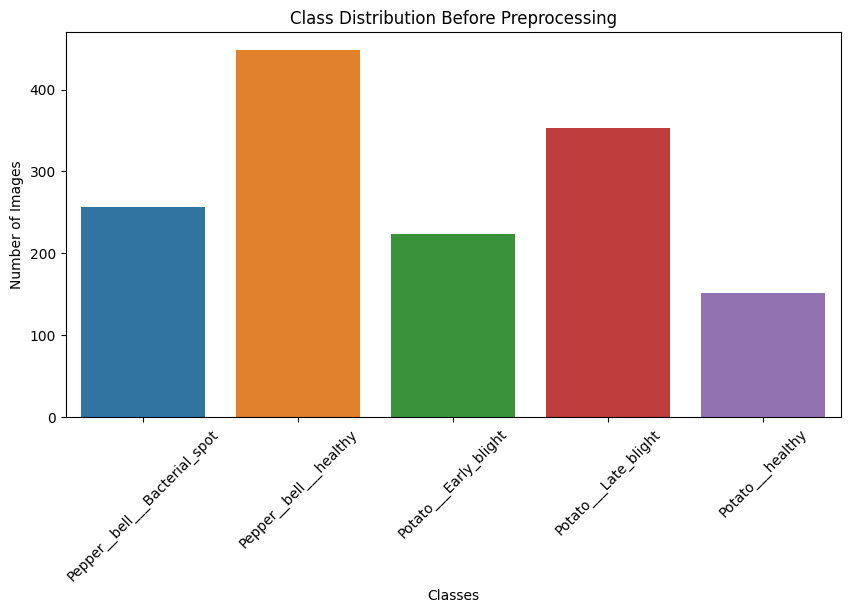

In [3]:
def plot_class_distribution(labels, title="Class Distribution"):
    class_counts = Counter(labels)
    keys, values = zip(*sorted(class_counts.items()))  # Sort keys and values
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keys), y=list(values))
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()


all_images = []
all_labels = []
for subdir in all_subdirs:
    class_name = os.path.basename(subdir)
    images = glob.glob(subdir + '/*.JPG')
    all_images.extend(images)
    all_labels.extend([class_name] * len(images))


plot_class_distribution(all_labels, title="Class Distribution Before Preprocessing")

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),  # Adding more augmentation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Adding more augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(root=VALIDATION_PATH, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=val_test_transform)

def show_sample_images(dataset, class_names, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.numpy()
        axes[i].imshow(img)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.show()

show_sample_images(train_dataset, train_dataset.classes)

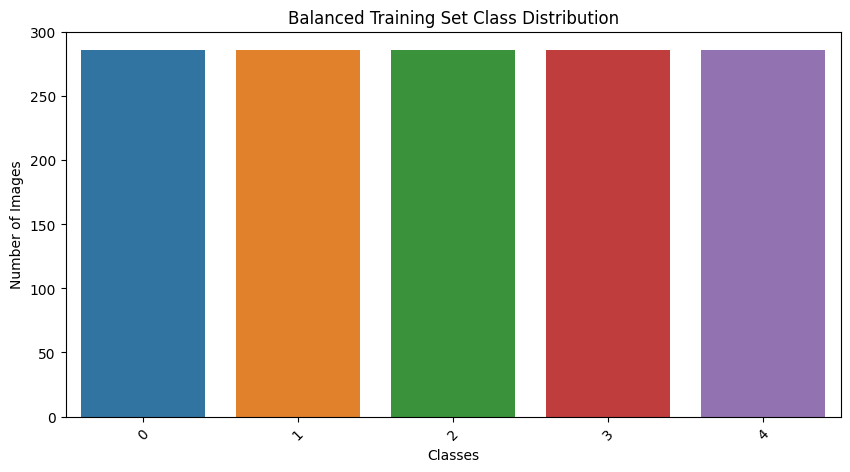

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


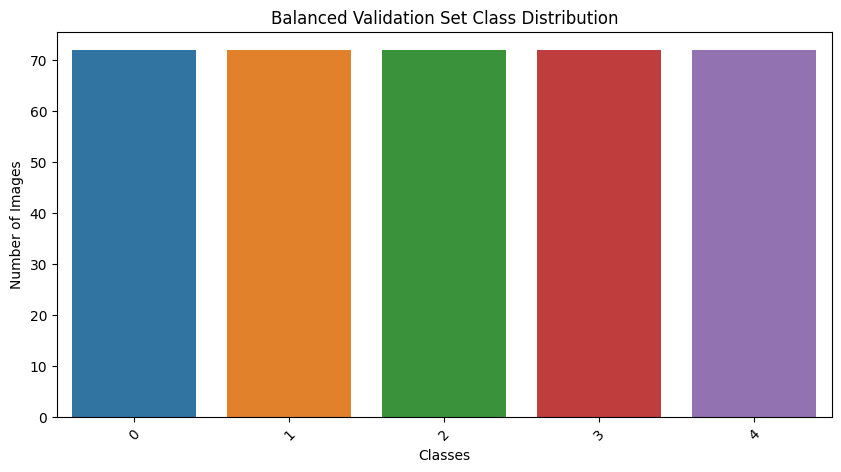

In [5]:
def plot_class_distribution(labels, title="Class Distribution"):
    class_counts = Counter(labels)
    keys, values = zip(*sorted(class_counts.items()))  # Sort keys and values
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(keys), y=list(values))
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

def balance_dataset(images, labels):
    class_counts = Counter(labels)
    max_count = max(class_counts.values())

    new_images = []
    new_labels = []

    for class_idx in np.unique(labels):
        class_images = [img for img, label in zip(images, labels) if label == class_idx]
        oversample_count = max_count - len(class_images)
        oversampled_images = np.random.choice(class_images, oversample_count, replace=True)

        new_images.extend(class_images + list(oversampled_images))
        new_labels.extend([class_idx] * (len(class_images) + oversample_count))

    return new_images, new_labels

train_images = [img_path for img_path, _ in train_dataset.samples]
train_labels = [label for _, label in train_dataset.samples]

val_images = [img_path for img_path, _ in val_dataset.samples]
val_labels = [label for _, label in val_dataset.samples]

balanced_train_images, balanced_train_labels = balance_dataset(train_images, train_labels)
balanced_val_images, balanced_val_labels = balance_dataset(val_images, val_labels)

plot_class_distribution(balanced_train_labels, title="Balanced Training Set Class Distribution")
plot_class_distribution(balanced_val_labels, title="Balanced Validation Set Class Distribution")

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = datasets.folder.default_loader(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

balanced_train_dataset = CustomImageDataset(balanced_train_images, balanced_train_labels, transform=train_transform)
balanced_val_dataset = CustomImageDataset(balanced_val_images, balanced_val_labels, transform=val_test_transform)

# **Restnet50 base**

In [16]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(num_ftrs, len(class_names))
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 50
batch_size = 32
patience = 3


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
train_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(balanced_val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=patience, verbose=True)

def train_model(model, criterion, optimizer, num_epochs):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                dataloader = train_loader
            else:
                model.eval() 
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

      
                optimizer.zero_grad()

 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                early_stopping(epoch_loss, model)

                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(torch.load('checkpoint.pt'))
                    return model, train_loss_history, val_loss_history
            else:
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

model, train_loss_history, val_loss_history = train_model(model, criterion, optimizer, num_epochs=num_epochs)


Epoch 0/49
----------
train Loss: 0.1400 Acc: 0.9476
val Loss: 0.2012 Acc: 0.9083
Validation loss decreased (inf --> 0.201206).  Saving model ...

Epoch 1/49
----------
train Loss: 0.1953 Acc: 0.9378
val Loss: 0.1760 Acc: 0.9389
Validation loss decreased (0.201206 --> 0.175971).  Saving model ...

Epoch 2/49
----------
train Loss: 0.2105 Acc: 0.9224
val Loss: 0.1498 Acc: 0.9472
Validation loss decreased (0.175971 --> 0.149772).  Saving model ...

Epoch 3/49
----------
train Loss: 0.1302 Acc: 0.9559
val Loss: 0.0944 Acc: 0.9500
Validation loss decreased (0.149772 --> 0.094449).  Saving model ...

Epoch 4/49
----------
train Loss: 0.1281 Acc: 0.9531
val Loss: 0.3717 Acc: 0.8861

Epoch 5/49
----------
train Loss: 0.1401 Acc: 0.9510
val Loss: 0.4980 Acc: 0.8722

Epoch 6/49
----------
train Loss: 0.1177 Acc: 0.9566
val Loss: 0.1076 Acc: 0.9639
Early stopping


In [25]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    acc = accuracy_score(all_labels, all_preds)
    
    print(f'Accuracy: {acc:.4f}')
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    return acc, cm, cr


test_acc, test_cm, test_cr = evaluate_model(model, test_loader, class_names)


Accuracy: 0.9791
Confusion Matrix:
 [[50  1  0  0  0]
 [ 0 90  0  0  0]
 [ 0  1 43  1  0]
 [ 1  0  1 69  0]
 [ 0  0  0  1 29]]
Classification Report:
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.98      0.98      0.98        51
       Pepper__bell___healthy       0.98      1.00      0.99        90
        Potato___Early_blight       0.98      0.96      0.97        45
         Potato___Late_blight       0.97      0.97      0.97        71
             Potato___healthy       1.00      0.97      0.98        30

                     accuracy                           0.98       287
                    macro avg       0.98      0.97      0.98       287
                 weighted avg       0.98      0.98      0.98       287



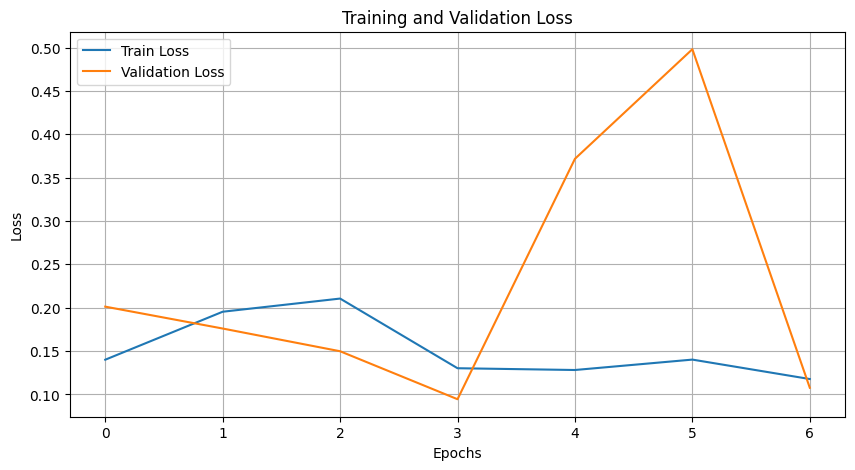

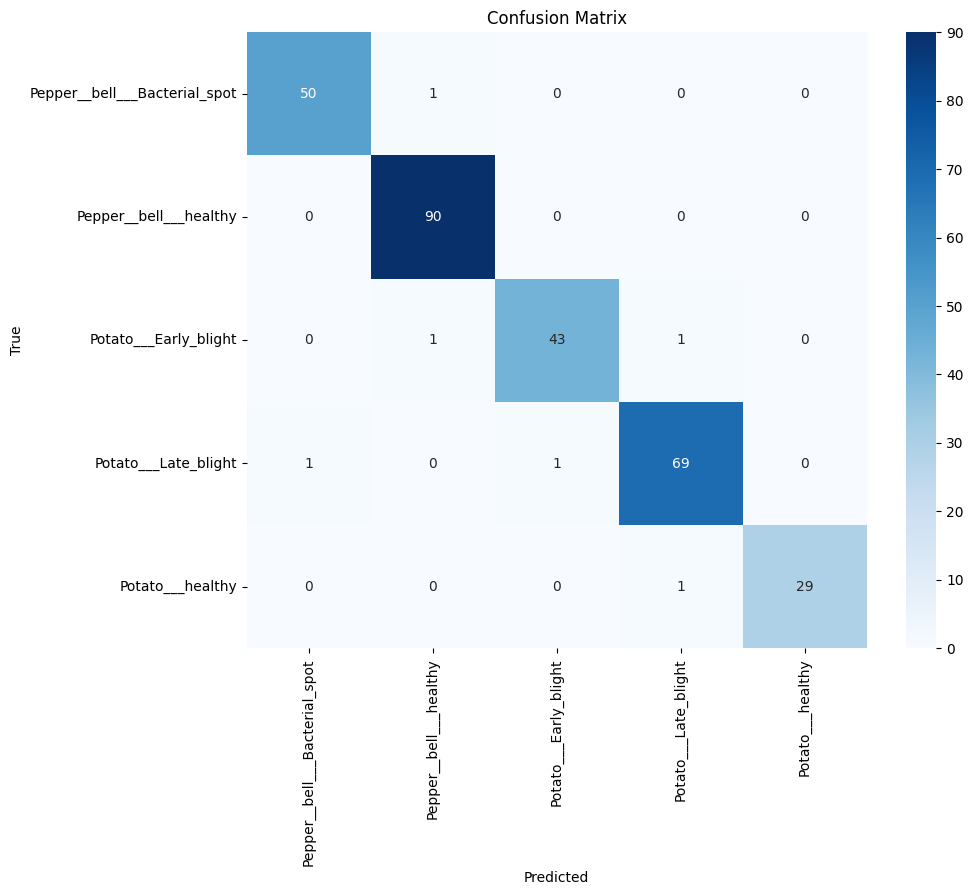

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


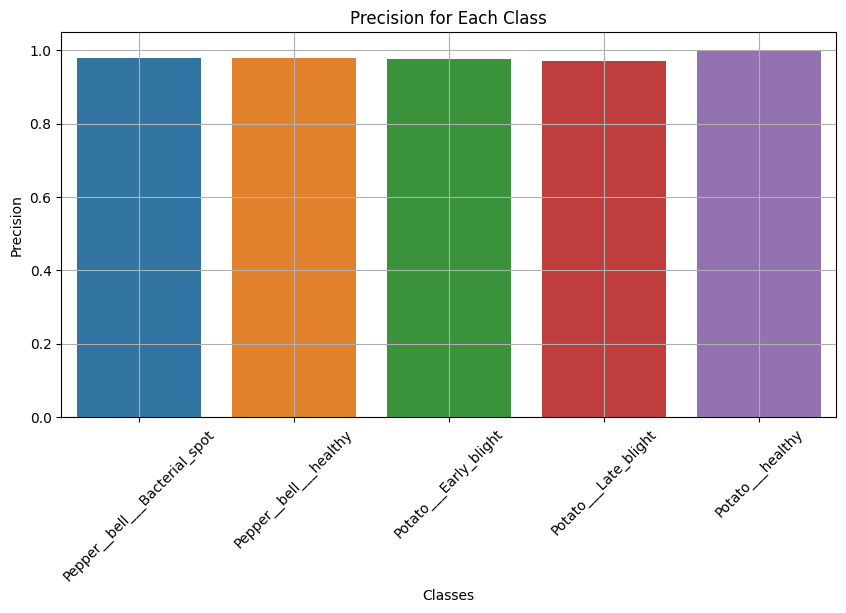

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


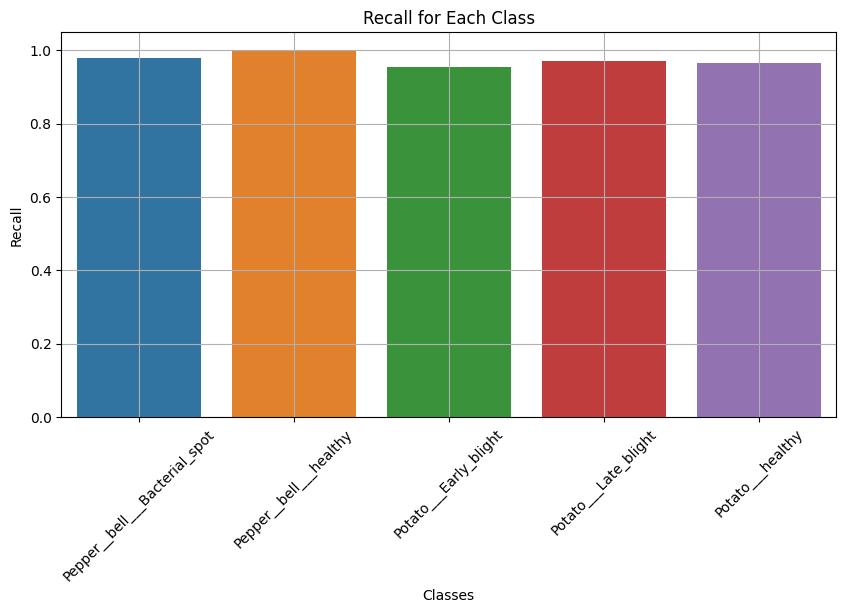

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


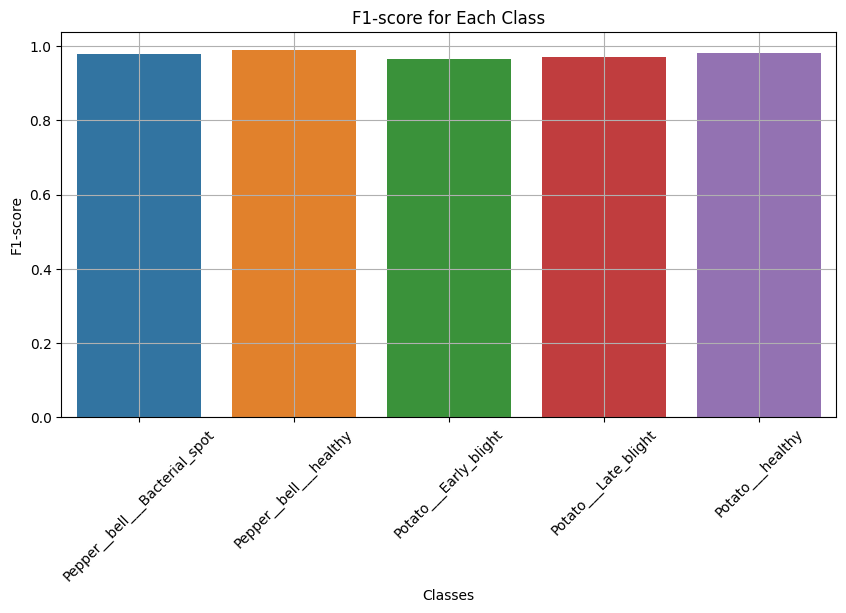

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_history)), train_loss_history, label='Train Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def plot_classification_report(cr):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(cr.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
    for metric in metrics:
        scores = [cr[cls][metric] for cls in classes]
        plt.figure(figsize=(10, 5))
        sns.barplot(x=classes, y=scores)
        plt.title(f'{metric.capitalize()} for Each Class')
        plt.xlabel('Classes')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

plot_classification_report(test_cr)


In [27]:
def measure_inference_time(model, dataloader, device):
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            _ = model(inputs)

    end_time = time.time()
    inference_time = end_time - start_time
    avg_inference_time = inference_time / len(dataloader.dataset)
    print(f'Average Inference Time per Image: {avg_inference_time:.6f} seconds')

    return avg_inference_time

avg_inference_time = measure_inference_time(model, test_loader, device)


Average Inference Time per Image: 0.002730 seconds


In [28]:
!pip install torchsummary

In [29]:
from torchsummary import summary

summary(model, (3, 224, 224))

model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model Size: {model_size} parameters')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# ***Creating custom model and evaluating without knowledge Distillation***

In [30]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = len(class_names)
student_model = CustomCNN(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(balanced_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'custom_cnn_checkpoint.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=3, verbose=True)

def train_student_model_without_distillation(model, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                early_stopping(epoch_loss, model)

                if early_stopping.early_stop:
                    print("Early stopping")
                    model.load_state_dict(torch.load('custom_cnn_checkpoint.pt'))
                    return model, train_loss_history, val_loss_history
            else:
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

student_model, student_train_loss_history, student_val_loss_history = train_student_model_without_distillation(student_model, criterion, student_optimizer, num_epochs=25)


Epoch 0/24
----------
train Loss: 1.9705 Acc: 0.2503
val Loss: 1.3213 Acc: 0.4278
Validation loss decreased (inf --> 1.321335).  Saving model ...

Epoch 1/24
----------
train Loss: 1.4140 Acc: 0.3839
val Loss: 1.3117 Acc: 0.4306
Validation loss decreased (1.321335 --> 1.311667).  Saving model ...

Epoch 2/24
----------
train Loss: 1.2442 Acc: 0.4706
val Loss: 1.1723 Acc: 0.5417
Validation loss decreased (1.311667 --> 1.172283).  Saving model ...

Epoch 3/24
----------
train Loss: 1.1728 Acc: 0.5336
val Loss: 1.0770 Acc: 0.6028
Validation loss decreased (1.172283 --> 1.077043).  Saving model ...

Epoch 4/24
----------
train Loss: 1.0604 Acc: 0.5692
val Loss: 0.8890 Acc: 0.6694
Validation loss decreased (1.077043 --> 0.889006).  Saving model ...

Epoch 5/24
----------
train Loss: 1.0409 Acc: 0.5895
val Loss: 0.8538 Acc: 0.6806
Validation loss decreased (0.889006 --> 0.853768).  Saving model ...

Epoch 6/24
----------
train Loss: 0.9646 Acc: 0.6147
val Loss: 0.8193 Acc: 0.7056
Validation 

Accuracy: 0.7805
Confusion Matrix:
 [[37 13  0  1  0]
 [10 75  0  3  2]
 [ 0  1 40  2  2]
 [11  2  5 46  7]
 [ 0  0  0  4 26]]
Classification Report:
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.64      0.73      0.68        51
       Pepper__bell___healthy       0.82      0.83      0.83        90
        Potato___Early_blight       0.89      0.89      0.89        45
         Potato___Late_blight       0.82      0.65      0.72        71
             Potato___healthy       0.70      0.87      0.78        30

                     accuracy                           0.78       287
                    macro avg       0.78      0.79      0.78       287
                 weighted avg       0.79      0.78      0.78       287



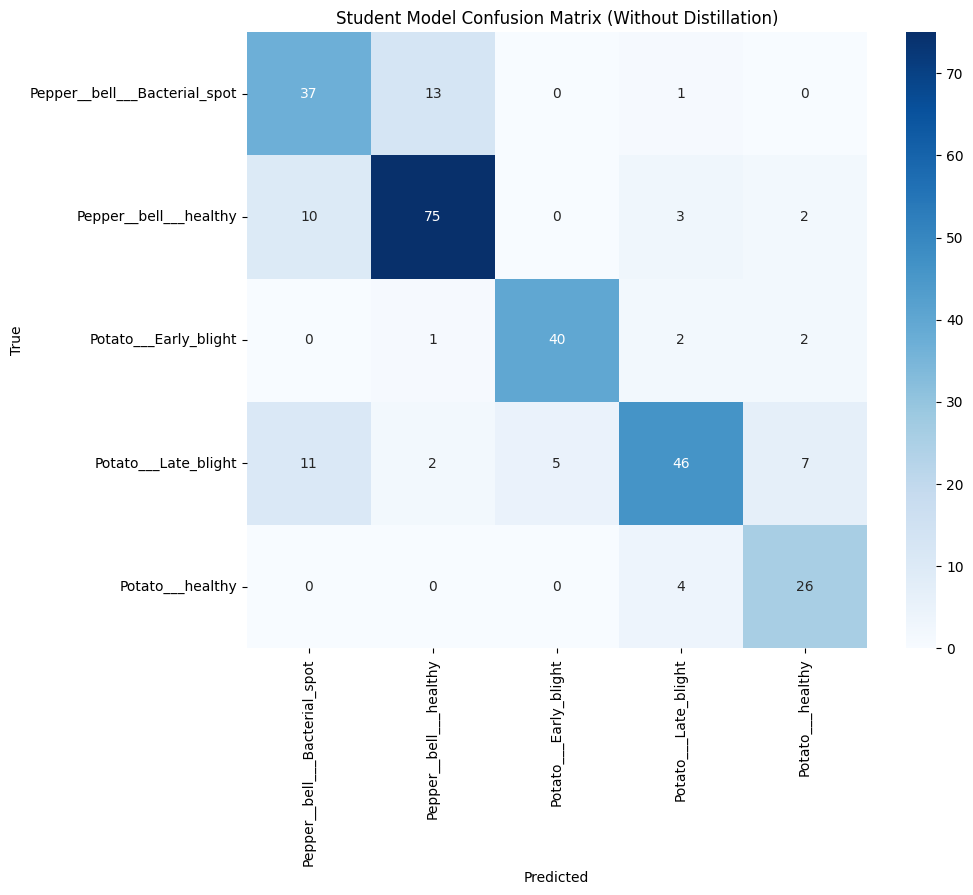

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


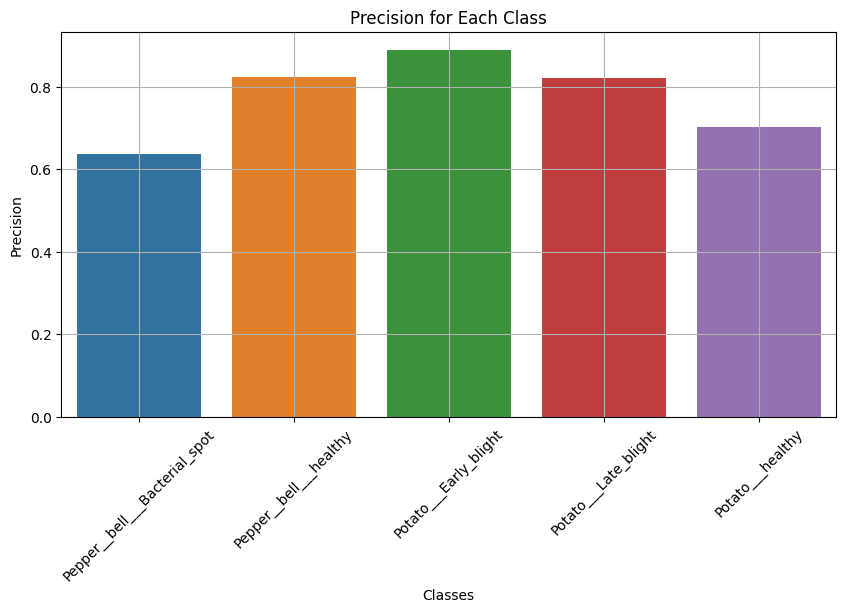

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


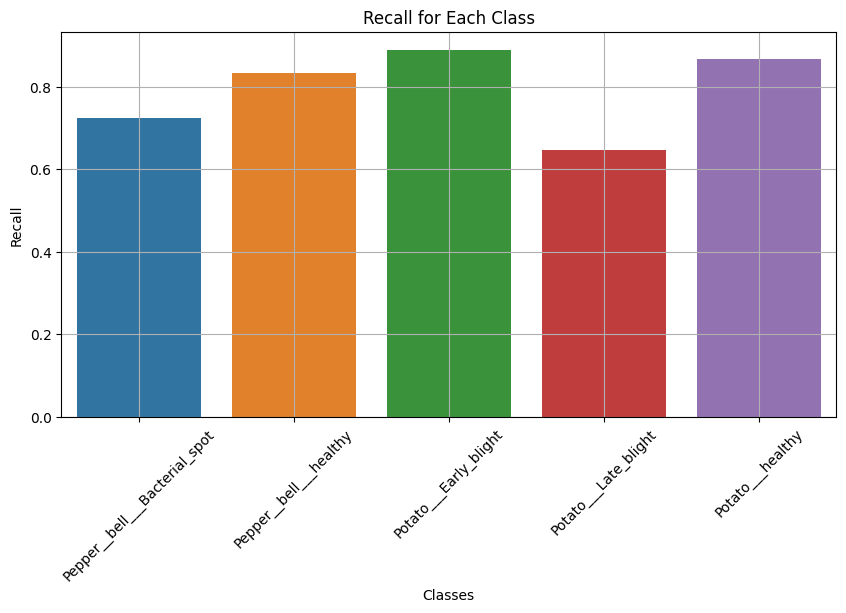

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


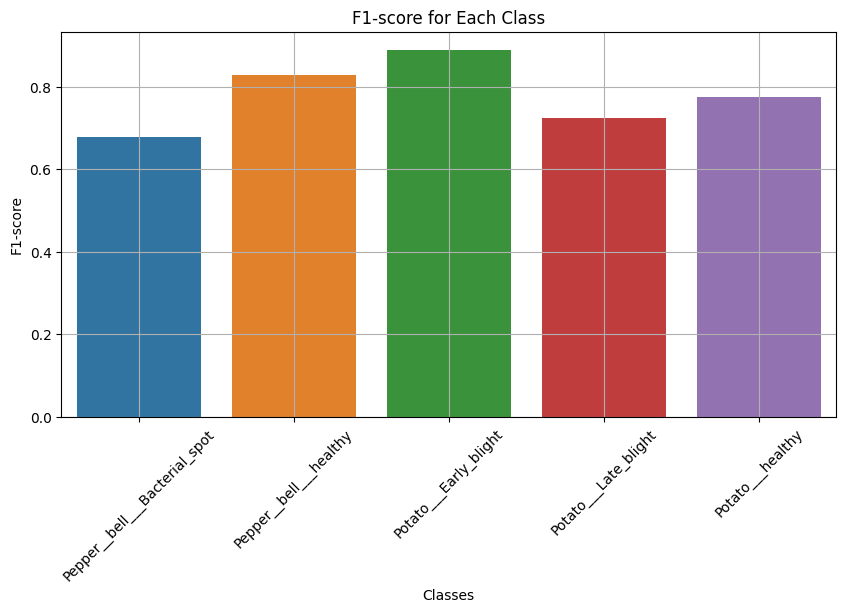

Average Inference Time per Image: 0.002463 seconds
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 512]      51,380,736
           Dropout-8                  [-1, 512]               0
            Linear-9                    [-1, 5]           2,565
Total params: 51,476,549
Trainable params: 51,476,549
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.80
Params size (MB): 196.37
Estimated Total

In [32]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    acc = accuracy_score(all_labels, all_preds)
    
    print(f'Accuracy: {acc:.4f}')
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    return acc, cm, cr


student_test_acc, student_test_cm, student_test_cr = evaluate_model(student_model, test_loader, class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(student_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Student Model Confusion Matrix (Without Distillation)')
plt.show()

def plot_classification_report(cr):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(cr.keys())[:-3]
    for metric in metrics:
        scores = [cr[cls][metric] for cls in classes]
        plt.figure(figsize=(10, 5))
        sns.barplot(x=classes, y=scores)
        plt.title(f'{metric.capitalize()} for Each Class')
        plt.xlabel('Classes')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

plot_classification_report(student_test_cr)

def measure_inference_time(model, dataloader, device):
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            _ = model(inputs)

    end_time = time.time()
    inference_time = end_time - start_time
    avg_inference_time = inference_time / len(dataloader.dataset)
    print(f'Average Inference Time per Image: {avg_inference_time:.6f} seconds')

    return avg_inference_time

student_avg_inference_time = measure_inference_time(student_model, test_loader, device)

summary(student_model, (3, 224, 224))
student_model_size = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
print(f'Student Model Size: {student_model_size} parameters')


# ***Applying Knowledge Distillation***

In [38]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=2.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        ce_loss = self.criterion(student_logits, labels)
        distillation_loss = nn.KLDivLoss()(F.log_softmax(student_logits / self.temperature, dim=1),
                                           F.softmax(teacher_logits / self.temperature, dim=1)) * (self.temperature * self.temperature)
        loss = self.alpha * ce_loss + (1 - self.alpha) * distillation_loss
        return loss

    
def train_student_model_with_distillation(teacher_model, student_model, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(student_model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                student_model.train()
                teacher_model.eval()
                dataloader = train_loader
            else:
                student_model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    student_outputs = student_model(inputs)
                    with torch.no_grad():
                        teacher_outputs = teacher_model(inputs)

                    loss = criterion(student_outputs, teacher_outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(student_outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                early_stopping(epoch_loss, student_model)

                if early_stopping.early_stop:
                    print("Early stopping")
                    student_model.load_state_dict(torch.load('custom_cnn_checkpoint.pt'))
                    return student_model, train_loss_history, val_loss_history
            else:
                train_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(student_model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    student_model.load_state_dict(best_model_wts)
    return student_model, train_loss_history, val_loss_history


student_model, student_train_loss_history, student_val_loss_history = train_student_model_with_distillation(
    model, student_model, distillation_criterion, student_optimizer, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.2620 Acc: 0.8832
val Loss: 0.6959 Acc: 0.7417
Validation loss decreased (inf --> 0.695859).  Saving model ...

Epoch 1/24
----------
train Loss: 0.2865 Acc: 0.8699
val Loss: 0.4427 Acc: 0.8056
Validation loss decreased (0.695859 --> 0.442668).  Saving model ...

Epoch 2/24
----------
train Loss: 0.2332 Acc: 0.8993
val Loss: 0.4751 Acc: 0.7611

Epoch 3/24
----------
train Loss: 0.2486 Acc: 0.8923
val Loss: 0.4890 Acc: 0.7528

Epoch 4/24
----------
train Loss: 0.2192 Acc: 0.9161
val Loss: 0.4398 Acc: 0.7778
Validation loss decreased (0.442668 --> 0.439756).  Saving model ...

Epoch 5/24
----------
train Loss: 0.2144 Acc: 0.9140
val Loss: 0.4406 Acc: 0.7583

Epoch 6/24
----------
train Loss: 0.2052 Acc: 0.9056
val Loss: 0.4656 Acc: 0.8083

Epoch 7/24
----------
train Loss: 0.1862 Acc: 0.9196
val Loss: 0.4644 Acc: 0.7667
Early stopping


Accuracy: 0.8676
Confusion Matrix:
 [[40 11  0  0  0]
 [10 76  2  0  2]
 [ 0  0 45  0  0]
 [ 0  0  4 65  2]
 [ 0  0  0  7 23]]
Classification Report:
                                precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.80      0.78      0.79        51
       Pepper__bell___healthy       0.87      0.84      0.86        90
        Potato___Early_blight       0.88      1.00      0.94        45
         Potato___Late_blight       0.90      0.92      0.91        71
             Potato___healthy       0.85      0.77      0.81        30

                     accuracy                           0.87       287
                    macro avg       0.86      0.86      0.86       287
                 weighted avg       0.87      0.87      0.87       287



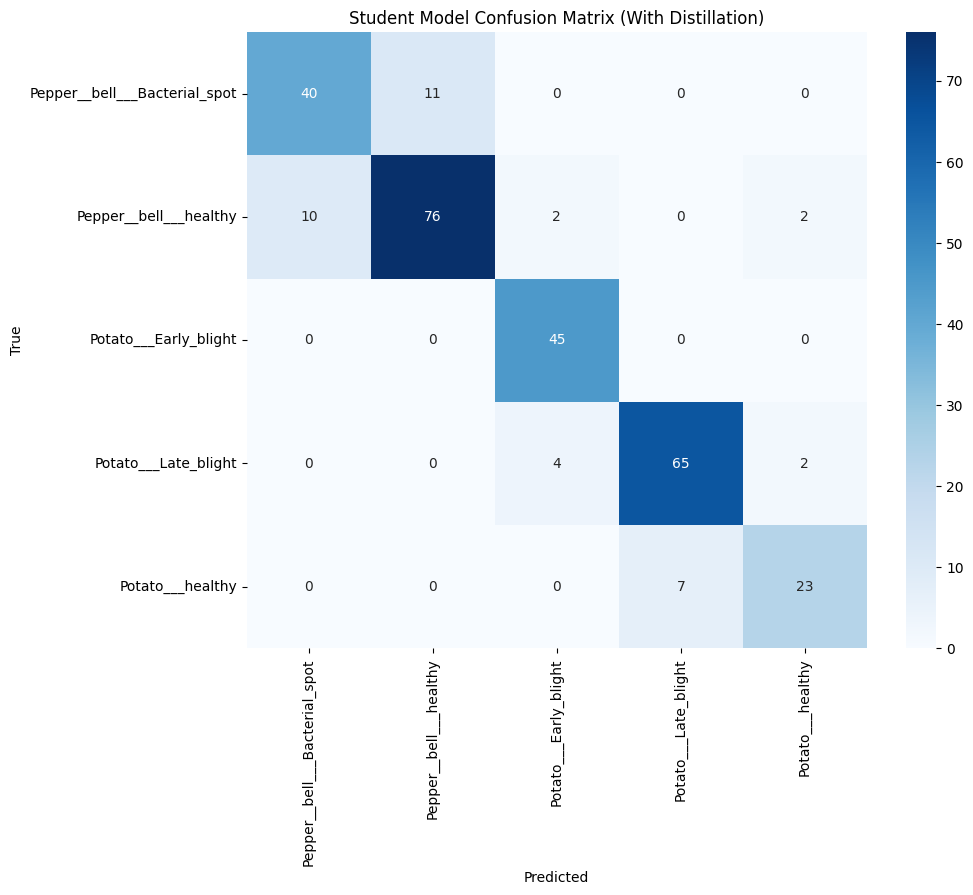

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


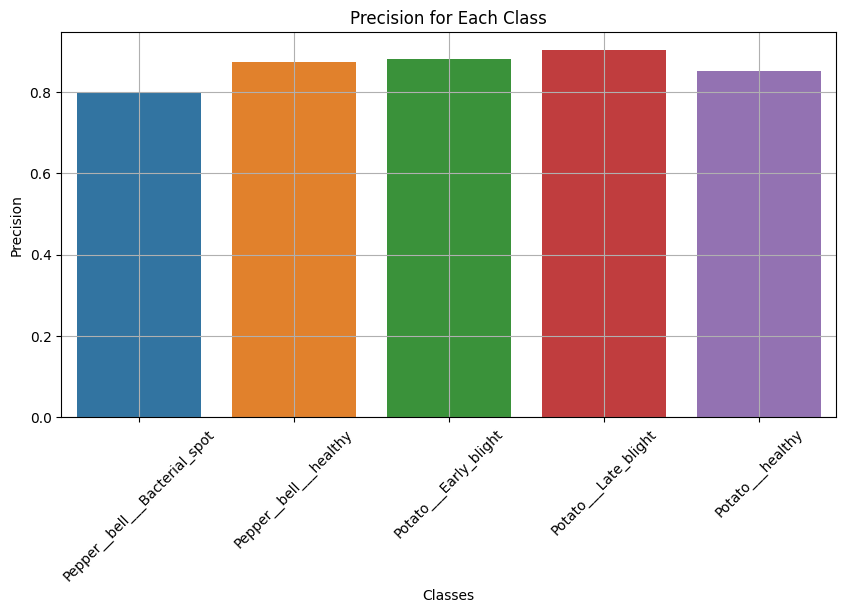

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


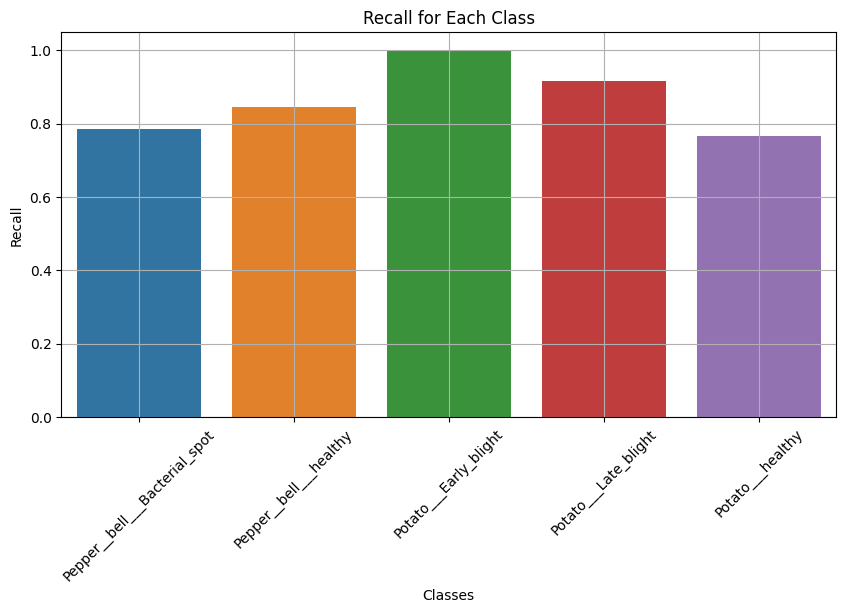

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


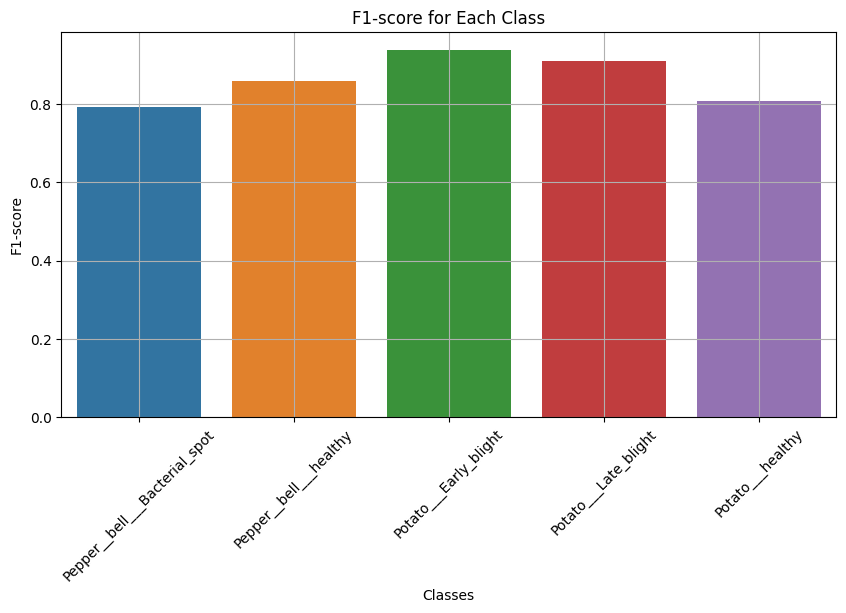

Average Inference Time per Image: 0.002490 seconds
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 512]      51,380,736
           Dropout-8                  [-1, 512]               0
            Linear-9                    [-1, 5]           2,565
Total params: 51,476,549
Trainable params: 51,476,549
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 26.80
Params size (MB): 196.37
Estimated Total

In [39]:
student_test_acc, student_test_cm, student_test_cr = evaluate_model(student_model, test_loader, class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(student_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Student Model Confusion Matrix (With Distillation)')
plt.show()

plot_classification_report(student_test_cr)

student_avg_inference_time = measure_inference_time(student_model, test_loader, device)

summary(student_model, (3, 224, 224))
student_model_size = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
print(f'Student Model Size: {student_model_size} parameters')


# **Comparing****

Teacher Model Size: 23518277 parameters
Student Model Size: 51476549 parameters
Teacher Model Inference Time per Image: 0.002730 seconds
Student Model Inference Time per Image: 0.002490 seconds


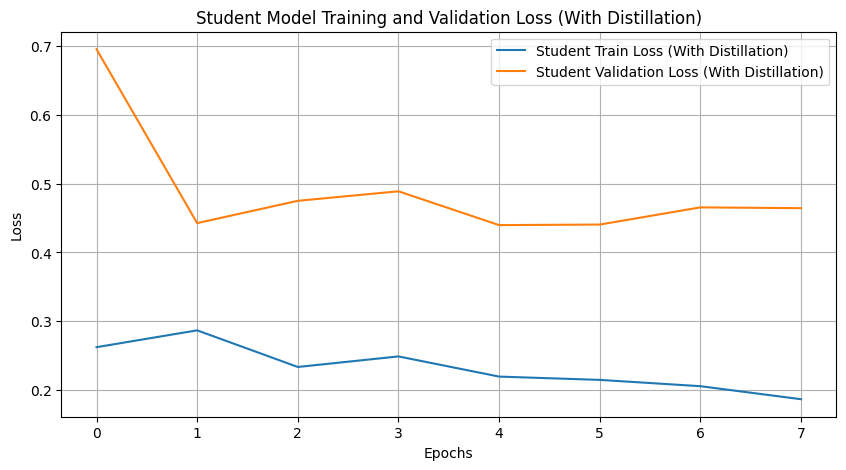

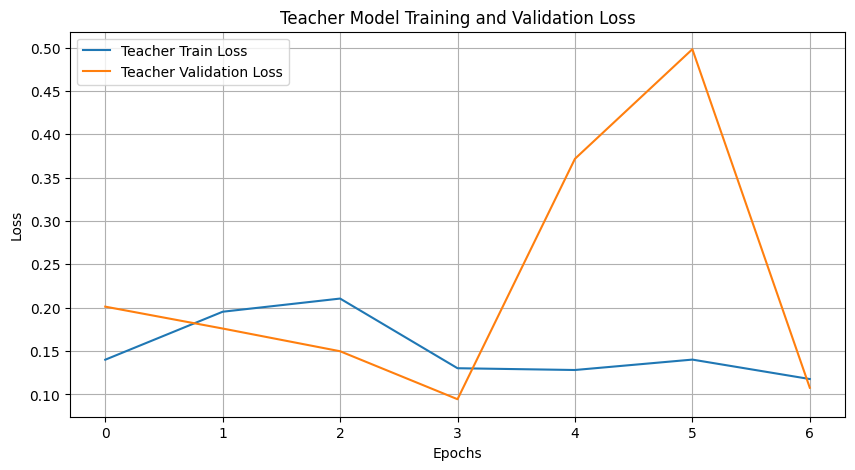

In [40]:
print(f'Teacher Model Size: {model_size} parameters')
print(f'Student Model Size: {student_model_size} parameters')

print(f'Teacher Model Inference Time per Image: {avg_inference_time:.6f} seconds')
print(f'Student Model Inference Time per Image: {student_avg_inference_time:.6f} seconds')

plt.figure(figsize=(10, 5))
plt.plot(range(len(student_train_loss_history)), student_train_loss_history, label='Student Train Loss (With Distillation)')
plt.plot(range(len(student_val_loss_history)), student_val_loss_history, label='Student Validation Loss (With Distillation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Student Model Training and Validation Loss (With Distillation)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_history)), train_loss_history, label='Teacher Train Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Teacher Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Teacher Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
